In [30]:
# system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz


# misc
import warnings

import glob

##
import pytz
import datetime as dt
import math
import seaborn as sns

In [31]:

import biosppy
from biosppy import storage
from biosppy.signals import ecg


# misc
import warnings

#signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

## Reading, extracting and slicing data (Psychopy and Shimmer)

In [32]:
def read_manipulate_psychopy(psychopy_path):
    
    psychopy_df = pd.read_csv(psychopy_path)
    col_list = [col for col in psychopy_df.columns if col.endswith('_ts')]
    col_list.insert(0, "Reference_time")
    psychopy_df_selected = psychopy_df[col_list]
    
    return psychopy_df_selected


def get_nonNan_list_psychopy(psychopy_df, col_name):
    
    
    selected_vals=[val for val in psychopy_df[col_name].to_list() if not(math.isnan(val))]
    
    return selected_vals



#######---------------------------------------------------
###### ------------------Shimmer--------------------------
###----------------------------------------------------------


def read_shimmer_sensor(sensor_file_path):
    
    shimmer_df = pd.read_csv(sensor_file_path, sep='\t', low_memory=False)
    shimmer_df = shimmer_df.reset_index()
    shimmer_df.columns = shimmer_df.iloc[0]
    shimmer_df.drop([0, 1], axis=0, inplace=True)
    shimmer_df=shimmer_df.reset_index(drop=True)
    
    return shimmer_df

def standardize_timestamps_shimmer(shimmer_df, timestamps_col_name):
    
    timesstamps_list = shimmer_df[timestamps_col_name].to_list()
    new_timestamps_list = [float(val)/1000 for val in  timesstamps_list]
    
    shimmer_df[timestamps_col_name] = new_timestamps_list
    
    return shimmer_df



def get_offset_timestamp(timestamp, offset_mins):
    
    time_zone = 'Europe/Berlin'
    tz = pytz.timezone(time_zone)
    local_time = dt.datetime.fromtimestamp(timestamp, tz)
    time_change = dt.timedelta(minutes=offset_mins)
    new_time = local_time + time_change
    new_timestamp =  dt.datetime.timestamp(new_time)
    return new_timestamp

def get_list_timestamp_interest(starting_timestamp, list_offset_mins):
    
    starting_timestamp_list=[]
    
    for offset_min in list_offset_mins:
        starting_timestamp_list.append(starting_timestamp)
        timestamp_offset = get_offset_timestamp(starting_timestamp, offset_min)
        starting_timestamp = timestamp_offset  
     
    
    #starting_timestamp_list = sorted(starting_timestamp_list, key = lambda x:float(x))
    return starting_timestamp_list
        
        

def slice_df_wrt_timestamps(df, start_timestamp, end_timestamp, timestamps_col):
    
    sliced_df=df[(df[timestamps_col]>= start_timestamp) & (df[timestamps_col] <= end_timestamp)]
    
    return sliced_df


def from_str_to_float(str_list):
    
    float_array =[float(val) for val in str_list]
    
    return float_array

def col_from_str_float (df, col_name):
    
    str_list = df[col_name].values
    
    float_array =[float(val) for val in str_list]
    
    df[col_name] = float_array
    
    return df

## HRV: Time Domain Analysis

In [33]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity



def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, int(np.median(peak_group)))
        
        
    #output = int(output)
    return output



def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))
        
 



def filter_rr(rr, throshold_high=0.5, threshold_low=0.5):
    
    #outlier_high = np.mean(rr) + throshold_high * np.std(rr)
    outlier_high =1500
    #print(outlier_high)
    
    rr_clean_high = [rr_val for rr_val in rr if rr_val <  outlier_high]
    
    rr_clean_high = np.array(rr_clean_high)
    
    #outlier_low = np.mean(rr_clean_high) - threshold_low*np.std(rr_clean_high)
    outlier_low = 400
    #print(outlier_low)
    
    rr_clean_high_low = [rr_val for rr_val in rr_clean_high if rr_val >  outlier_low]
    
    rr_clean_high_low= np.array(rr_clean_high_low)
    
    return rr_clean_high_low


        
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    #results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

## HRV: Frequency Domain

In [34]:
def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

## Fetchin info and calculate mean and standard deviation 

In [35]:
def get_mean_std_event_list(psychopy_df, shimmer_df_selected, event_interest_list_new, offset_min_list_new, timestamp_sensor_col_name, data_col_name):

    mean_cumm_list = []
    std_cumm_list  = []
    event_interets_plot = []
    
    all_rr_one_list = []
    all_rr_sublist = []
    
    
    
    
    


    ##---outer loop to hnadle muultiple offsets from the selected events 
    for ind, event_selected in enumerate(event_interest_list_new):

        offset_list_selected_event = offset_min_list_new[ind]

        #print(event_selected)

        current_event_timestamp = get_nonNan_list_psychopy(psychopy_df, event_selected)[0]

        offset_min_list_selected = offset_min_list_new[ind]
        
        acc_min_print = 0

        for offset_min in offset_min_list_selected:
            
            offset_min_print = offset_min + acc_min_print
            
            acc_min_print = offset_min_print

            event_plot = event_selected +" "+ str(offset_min_print) + " min"
            
            print(event_plot)
            
            event_interets_plot.append(event_plot)

            timestamp_offset = get_offset_timestamp(current_event_timestamp, offset_min)

            start_end_time_list = [current_event_timestamp, timestamp_offset]

            timestamp_start_slice = min(start_end_time_list)

            timestamp_end_slice = max(start_end_time_list)

            sensor_df_ii=slice_df_wrt_timestamps(shimmer_df_selected, timestamp_start_slice, timestamp_end_slice, timestamp_sensor_col_name)
            
            #print(sensor_df_ii)
            
            ecg_df_ii=sensor_df_ii.reset_index(drop=True)
            
            
            #cond_slice_main = (ecg_df_ii[timestamp_sensor_col_name] >= timestamp_start_slice) & (ecg_df_ii[timestamp_sensor_col_name] < timestamp_end_slice)
            
            ecg_slice = ecg_df_ii.heartrate
            
            out = ecg.ecg(signal=ecg_slice, sampling_rate=256, show=True,interactive=False)
            
            r_peaks = out["rpeaks"]
            
            r_peaks_sec = r_peaks*1/256
            r_peaks_msec = r_peaks_sec*1000

            r_peaks_diff=np.diff(r_peaks_msec)
            
            
            print(timedomain(r_peaks_diff))
            

            
            #peaks, similarity = detect_peaks(ecg_slice, threshold=0.3)
            #grouped_peaks = group_peaks(peaks)
            #grouped_peak_msec =group_peaks_from_ind_to_msec(grouped_peaks, 256)
            #rr = np.diff(grouped_peak_msec)
            #print(timedomain(rr))
            
            
            #cleaned_rr = filter_rr(r_peaks_diff)
            cleaned_rr=r_peaks_diff
            mean_rr = np.mean(cleaned_rr) 
            std_rr = np.std(cleaned_rr)
            
            mean_cumm_list.append(mean_rr)
            std_cumm_list.append(std_rr)
            
            all_rr_one_list.extend(cleaned_rr)
            all_rr_sublist.append(cleaned_rr)
            
            
            #event_interets_plot
            
            #print(np.mean(cleaned_rr))
            #print(np.std(cleaned_rr))
            


            current_event_timestamp = timestamp_offset
            
            
            
    return mean_cumm_list, std_cumm_list, event_interets_plot, all_rr_one_list, all_rr_sublist

## Paths and files

In [36]:
data_dir_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp4_tester"
#data_dir_path = "D:/Datasets/data_sony_digiRelax/study"
sub_dirs=next(os.walk(data_dir_path))[1]

In [37]:
sub_dirs

['VP069_110124']

In [38]:
event_interest_list_new = ["baseline_instruction_ts", "tsst_prep_ts", "tsst_pres_ts", "relaxation_prep_ts"]
offset_min_list_new  = [[3], [5], [5,5], [5, 5, 5]]

In [39]:
dest_path ="/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp4/results_all_sub"
#dest_path = "D:/Datasets/analysis_digirelax"
designated_folder = "hrv_analysis"
comp_dest_path = os.path.join(dest_path, designated_folder)

isexist = os.path.exists(comp_dest_path)

if not isexist:
    os.makedirs(comp_dest_path)
    print("The new directory is created")

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp4_tester/VP069_110124/Psychopy_data/VP069_110124_DigiRelax_Experiment_2024-01-11_09h51.14.639.csv
VP069_110124_DigiRelax_Experiment_2024-01-11_09h51.14.639
baseline_instruction_ts 3 min


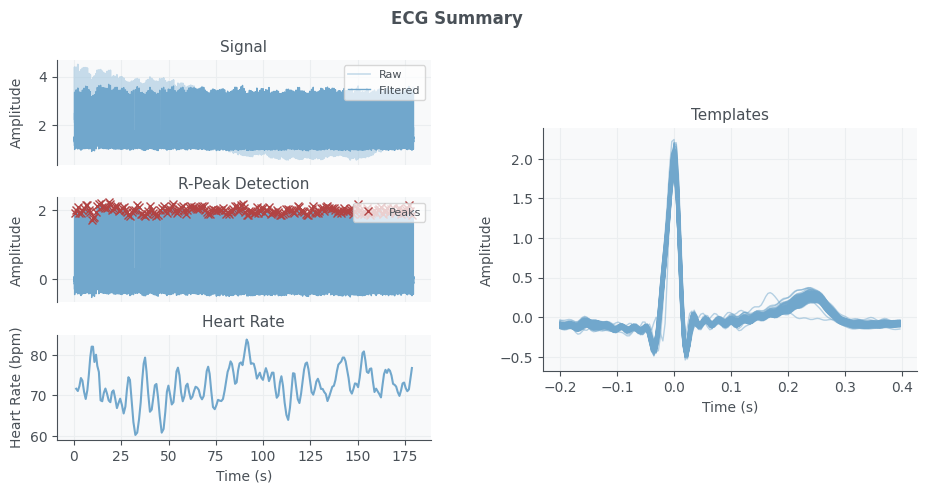

{'Mean RR (ms)': 829.0879360465116, 'STD RR/SDNN (ms)': 58.724983175596634, 'Mean HR (beats/min)': 72.72418634382157, 'STD HR (beats/min)': 5.0469342614152986, 'Min HR (beats/min)': 58.18181818181818, 'Max HR (beats/min)': 89.30232558139535, 'RMSSD (ms)': 45.637193212100826, 'NNxx': 62, 'pNNxx (%)': 28.837209302325583}
tsst_prep_ts 5 min


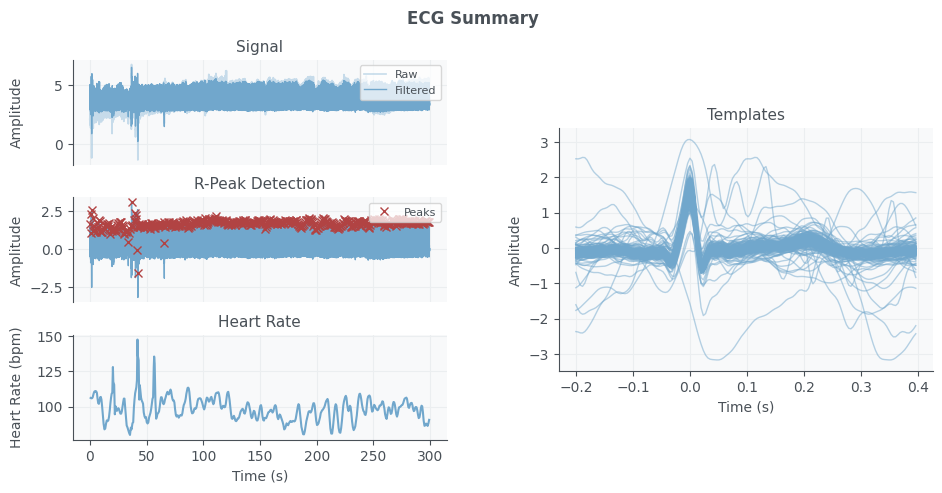

{'Mean RR (ms)': 612.4087474385246, 'STD RR/SDNN (ms)': 55.87715407411609, 'Mean HR (beats/min)': 98.86639025878289, 'STD HR (beats/min)': 10.222568208694483, 'Min HR (beats/min)': 74.92682926829268, 'Max HR (beats/min)': 199.4805194805195, 'RMSSD (ms)': 43.39611534109077, 'NNxx': 34, 'pNNxx (%)': 6.967213114754099}
tsst_pres_ts 5 min


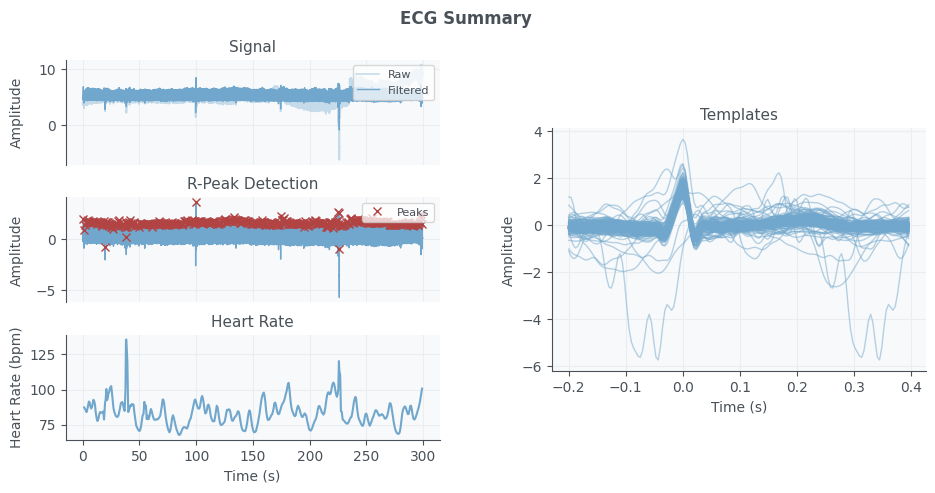

{'Mean RR (ms)': 719.0512048192771, 'STD RR/SDNN (ms)': 80.45141526912025, 'Mean HR (beats/min)': 84.85870879509513, 'STD HR (beats/min)': 14.368963075335104, 'Min HR (beats/min)': 66.78260869565217, 'Max HR (beats/min)': 279.27272727272725, 'RMSSD (ms)': 53.985107705357855, 'NNxx': 48, 'pNNxx (%)': 11.566265060240964}
tsst_pres_ts 10 min


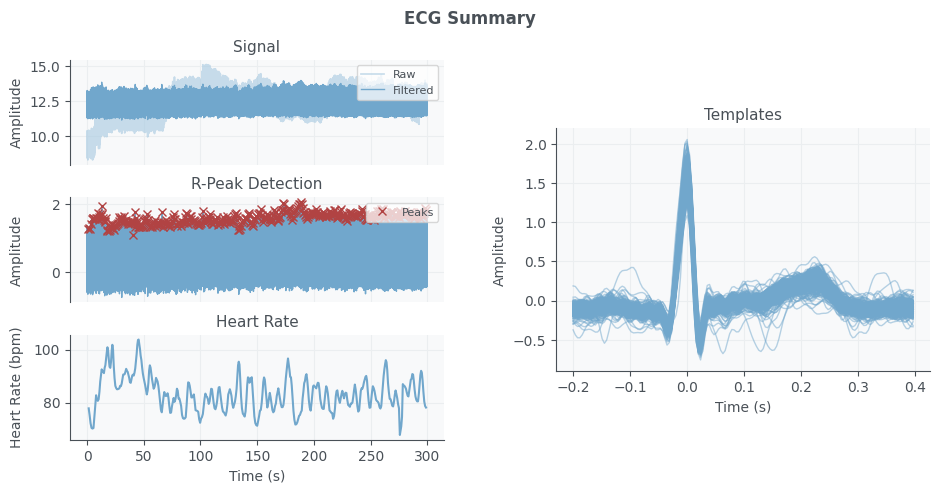

{'Mean RR (ms)': 721.74825968523, 'STD RR/SDNN (ms)': 62.45851342747781, 'Mean HR (beats/min)': 83.72774371541468, 'STD HR (beats/min)': 7.012476552633766, 'Min HR (beats/min)': 49.23076923076923, 'Max HR (beats/min)': 105.93103448275862, 'RMSSD (ms)': 45.25986517594636, 'NNxx': 52, 'pNNxx (%)': 12.590799031476998}
relaxation_prep_ts 5 min


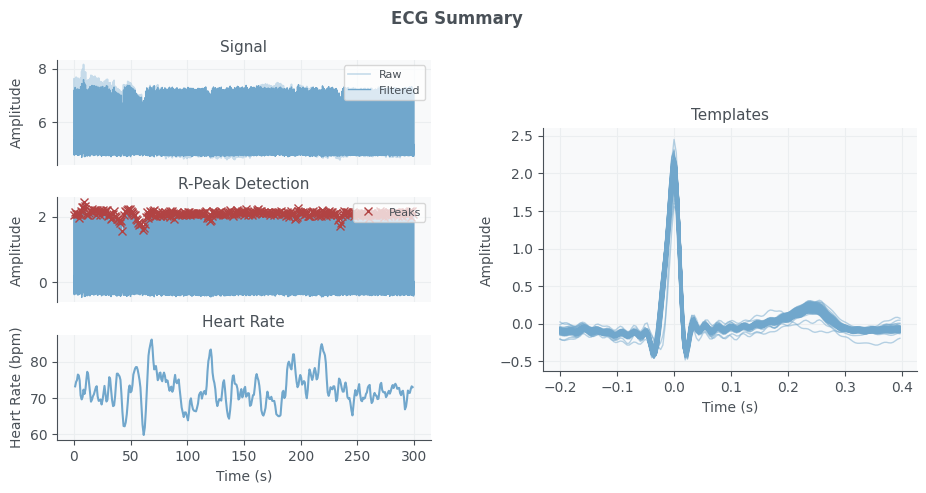

{'Mean RR (ms)': 831.4327994428969, 'STD RR/SDNN (ms)': 57.56834515224547, 'Mean HR (beats/min)': 72.50911576828287, 'STD HR (beats/min)': 5.002316772371959, 'Min HR (beats/min)': 57.100371747211895, 'Max HR (beats/min)': 87.77142857142857, 'RMSSD (ms)': 40.88526145236761, 'NNxx': 83, 'pNNxx (%)': 23.119777158774372}
relaxation_prep_ts 10 min


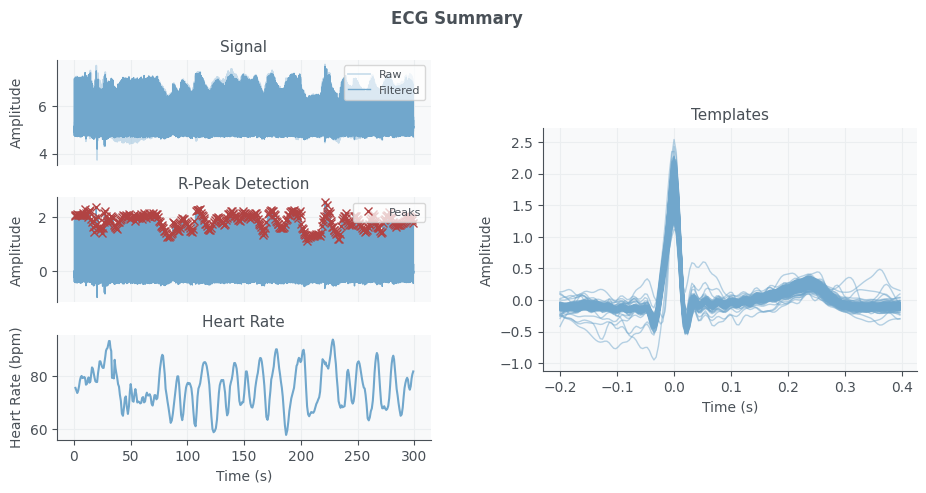

{'Mean RR (ms)': 793.9245345744681, 'STD RR/SDNN (ms)': 87.55047611574072, 'Mean HR (beats/min)': 76.46476067440003, 'STD HR (beats/min)': 8.143514092908093, 'Min HR (beats/min)': 56.470588235294116, 'Max HR (beats/min)': 94.23312883435582, 'RMSSD (ms)': 48.5524509658541, 'NNxx': 87, 'pNNxx (%)': 23.138297872340427}
relaxation_prep_ts 15 min


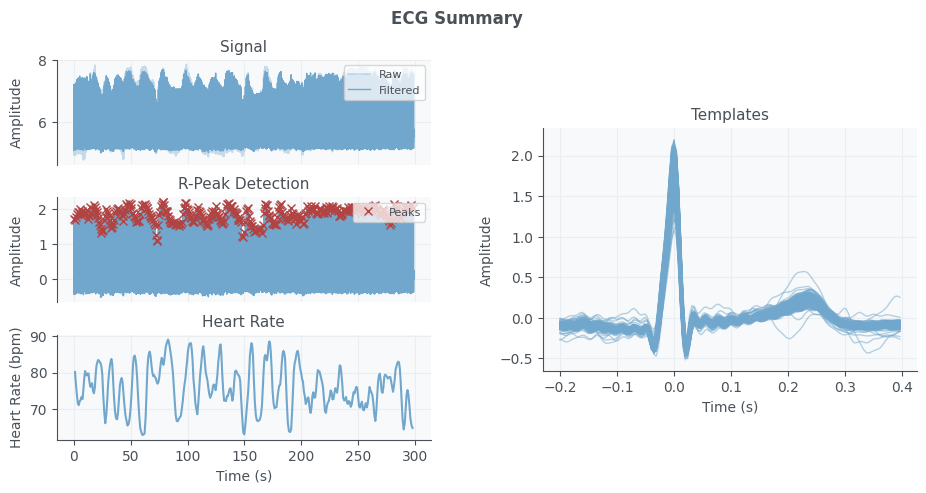

{'Mean RR (ms)': 791.9090757978723, 'STD RR/SDNN (ms)': 70.31490378806123, 'Mean HR (beats/min)': 76.3515393999232, 'STD HR (beats/min)': 6.623510056328838, 'Min HR (beats/min)': 61.935483870967744, 'Max HR (beats/min)': 89.82456140350877, 'RMSSD (ms)': 38.14815297653129, 'NNxx': 66, 'pNNxx (%)': 17.5531914893617}


In [40]:
for sub_dir in sub_dirs:
    
    sub_dir_path= os.path.join(data_dir_path, sub_dir)
    psychopy_file_path = os.path.join(sub_dir_path, "Psychopy_data")
    psychopy_file_path = glob.glob(psychopy_file_path+ "/*.csv")[0]
    print(psychopy_file_path)
    
    psychopy_df = read_manipulate_psychopy(psychopy_file_path)
    
    shimmer_files_subdir = os.path.join(sub_dir_path, "Shimmer_data")
    shimmer_files_subdir_subdir_name = next(os.walk(shimmer_files_subdir))[1][0]
    shimmer_files_parent_path = os.path.join(shimmer_files_subdir, shimmer_files_subdir_subdir_name)
    shimmer_files_name = glob.glob(shimmer_files_parent_path+ "/*.csv")
    
    #print(shimmer_files_name)
    
    for sh_file in shimmer_files_name:
        
        if '_6B1E_' in sh_file:
            hr_shimmer_path = sh_file
            
    fol_path, file_name=os.path.split(psychopy_file_path)
    sub_id=file_name[:-4]
    print(sub_id)
    
    ## heart rate
    timestamp_hr_col = "Shimmer_6B1E_Timestamp_Unix_CAL"
    ecg_col_name = "Shimmer_6B1E_ECG_LL-LA_24BIT_CAL"
    
    hr_df=read_shimmer_sensor(hr_shimmer_path)
    hr_df = standardize_timestamps_shimmer(hr_df, timestamp_hr_col)
    
    selected_ecg_df = hr_df[[timestamp_hr_col, ecg_col_name]]
    selected_ecg_df = selected_ecg_df.copy()
    selected_ecg_df['heartrate'] = selected_ecg_df[ecg_col_name]
    selected_ecg_df=col_from_str_float(selected_ecg_df, "heartrate")
    
    mean_hrv_list,std_hrv_list, event_interets_plot, all_rr_one_list, all_rr_sublist =  get_mean_std_event_list(psychopy_df, selected_ecg_df, event_interest_list_new, offset_min_list_new, timestamp_hr_col, "heartrate")
    
    #norm_mean_hrv, norm_std_hrv = min_max_norm(all_rr_one_list, all_rr_sublist)
    
    #export_dict= {"subject_id":sub_id , 'event_interst': event_interets_plot, "mean_hrv":mean_hrv_list , "std_hrv": std_hrv_list , "norm_mean_hrv":norm_mean_hrv,  "norm_std_hrv": norm_std_hrv}
    
     
    #dest_path_csv = os.path.join(comp_dest_path,file_name)
    #df_export = pd.DataFrame.from_dict(export_dict)
    #df_export.to_csv(dest_path_csv)